In [101]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)

In [102]:
G20_economic_data <- read_csv("https://raw.githubusercontent.com/mparhar1/DSCI-100-Group-48-Project/main/WEOApri23G20.csv")
colnames(G20_economic_data) <- make.names(colnames(G20_economic_data), unique = TRUE)

can_economic_df <- G20_economic_data |>
    select(Country,
           Subject.Descriptor,
           Units,
           X2010:X2023
          ) |>
    filter(Subject.Descriptor == "Gross domestic product per capita, current prices" & Units == "U.S. dollars" |
           Subject.Descriptor == "Volume of imports of goods and services" |
           Subject.Descriptor == "Volume of exports of goods and services" | 
           Subject.Descriptor == "Inflation, average consumer prices" & Units == "Percent change" |
           Subject.Descriptor == "Unemployment rate"
          ) |>
    filter(Country == "Canada") |>
    mutate(X2014 = as.numeric(gsub(",","", X2014)),
           X2015 = as.numeric(gsub(",","", X2015)),
           X2016 = as.numeric(gsub(",","", X2016)),
           X2022 = as.numeric(gsub(",","", X2022)),
           X2023 = as.numeric(gsub(",","", X2023)),
          ) |>
    pivot_longer(cols = X2010:X2023,
                 names_to = "Year",
                 values_to = "Metric"
                ) |>
    group_by(Country, Year, Subject.Descriptor) |>
    summarise(Metric = mean(Metric, na.rm = TRUE)) |>
    pivot_wider(names_from = Subject.Descriptor,
                values_from = Metric
               )

colnames(can_economic_df) <- make.names(colnames(can_economic_df), unique = TRUE)

can_economic_df

Rows: 836 Columns: 59
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (46): ISO, WEO Subject Code, Country, Subject Descriptor, Subject Notes,...
dbl  (2): WEO Country Code, Estimates Start After

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Country', 'Year'. You can override using
the `.groups` argument.


Country,Year,Gross.domestic.product.per.capita..current.prices,Inflation..average.consumer.prices,Unemployment.rate,Volume.of.exports.of.goods.and.services,Volume.of.imports.of.goods.and.services
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Canada,X2010,47627.35,1.777,8.142,6.678,13.788
Canada,X2011,52285.94,2.912,7.617,4.828,5.594
Canada,X2012,52744.00,1.516,7.408,2.815,3.709
Canada,X2013,52708.61,0.938,7.175,2.461,2.077
Canada,X2014,51020.84,1.907,7.033,6.323,2.531
Canada,X2015,43626.47,1.125,6.950,3.419,0.751
Canada,X2016,42382.64,1.429,7.033,1.407,0.051
Canada,X2017,45191.99,1.597,6.408,1.445,4.627
Canada,X2018,46625.86,2.268,5.850,3.825,3.309


mean,median,st.dev
<dbl>,<dbl>,<dbl>
48066.37,47126.61,3874.768


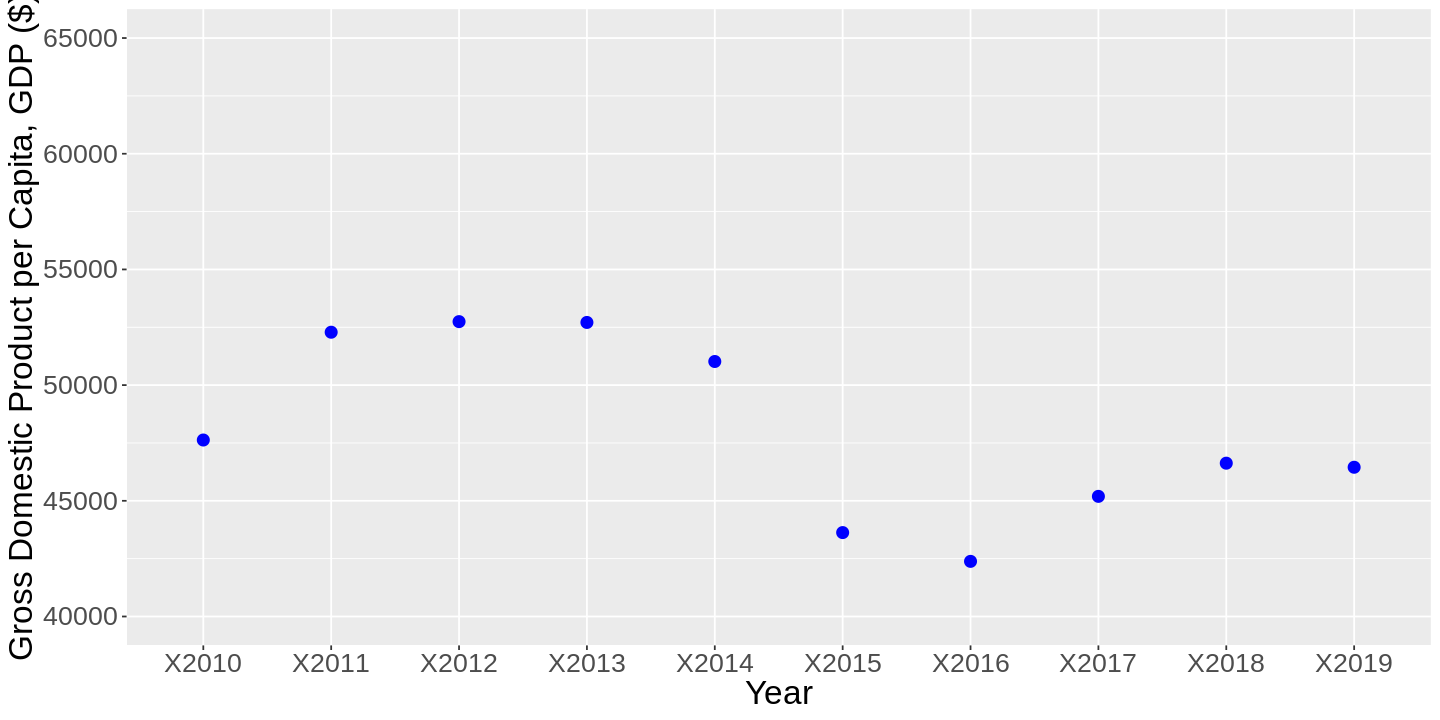

In [103]:
set.seed(100)

canada_pre_2020_df <- filter(can_economic_df, Country == "Canada" & Year <= "X2019")

can_gdp_summary_table <- canada_pre_2020_df |>
    ungroup() |>
    summarize(mean = mean(Gross.domestic.product.per.capita..current.prices),
              median = median(Gross.domestic.product.per.capita..current.prices),
              st.dev = sd(Gross.domestic.product.per.capita..current.prices),
             )

can_gdp_training_visual <- canada_pre_2020_df |>
    ggplot(aes(x = Year, y = Gross.domestic.product.per.capita..current.prices)) + 
        geom_point(color = "blue", size = 3) + 
        ylim(min=40000, max=65000) +
        xlab("Year") +
        ylab("Gross Domestic Product per Capita, GDP ($)") + 
        theme(text = element_text(size = 20))

can_gdp_summary_table
can_gdp_training_visual

Above we extracted the data of Canada's GDP, computed its mean, median and, standard deviation then plotted a 
visualization over a course of 9 years.

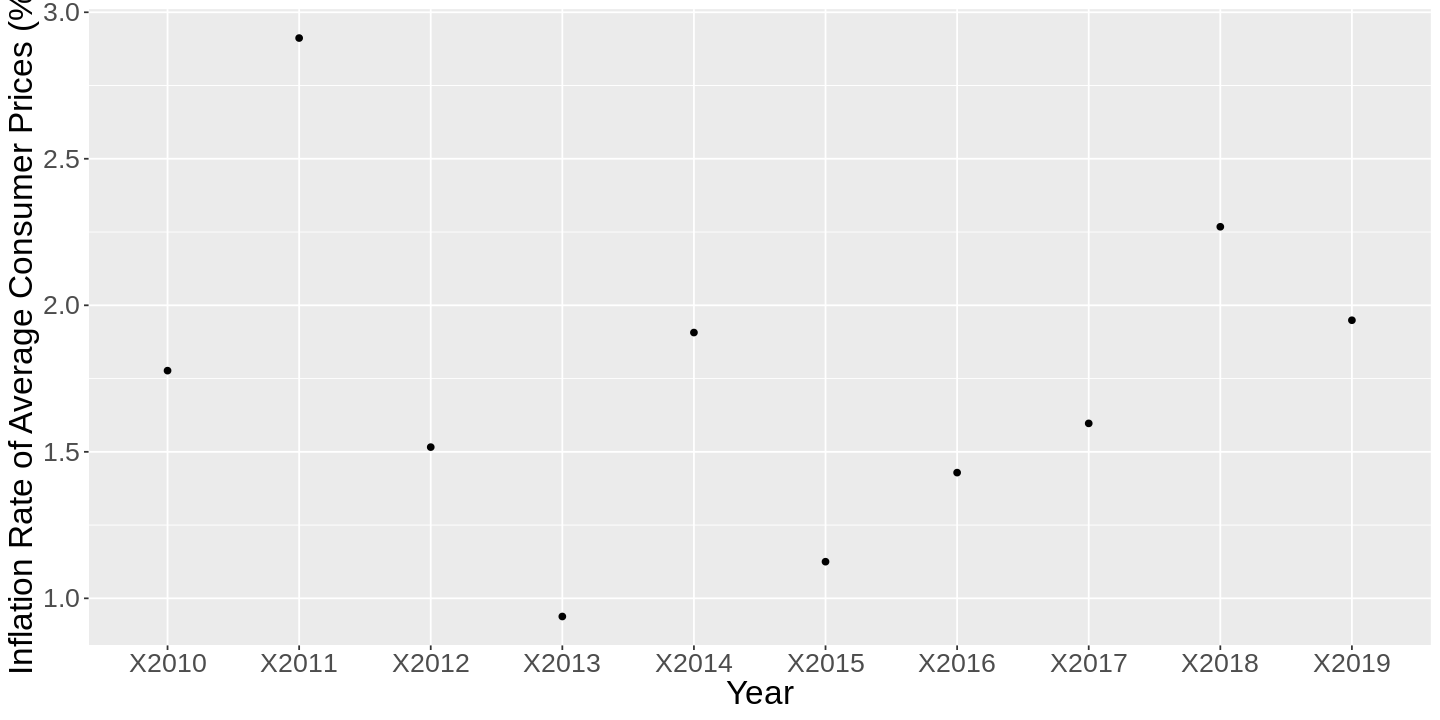

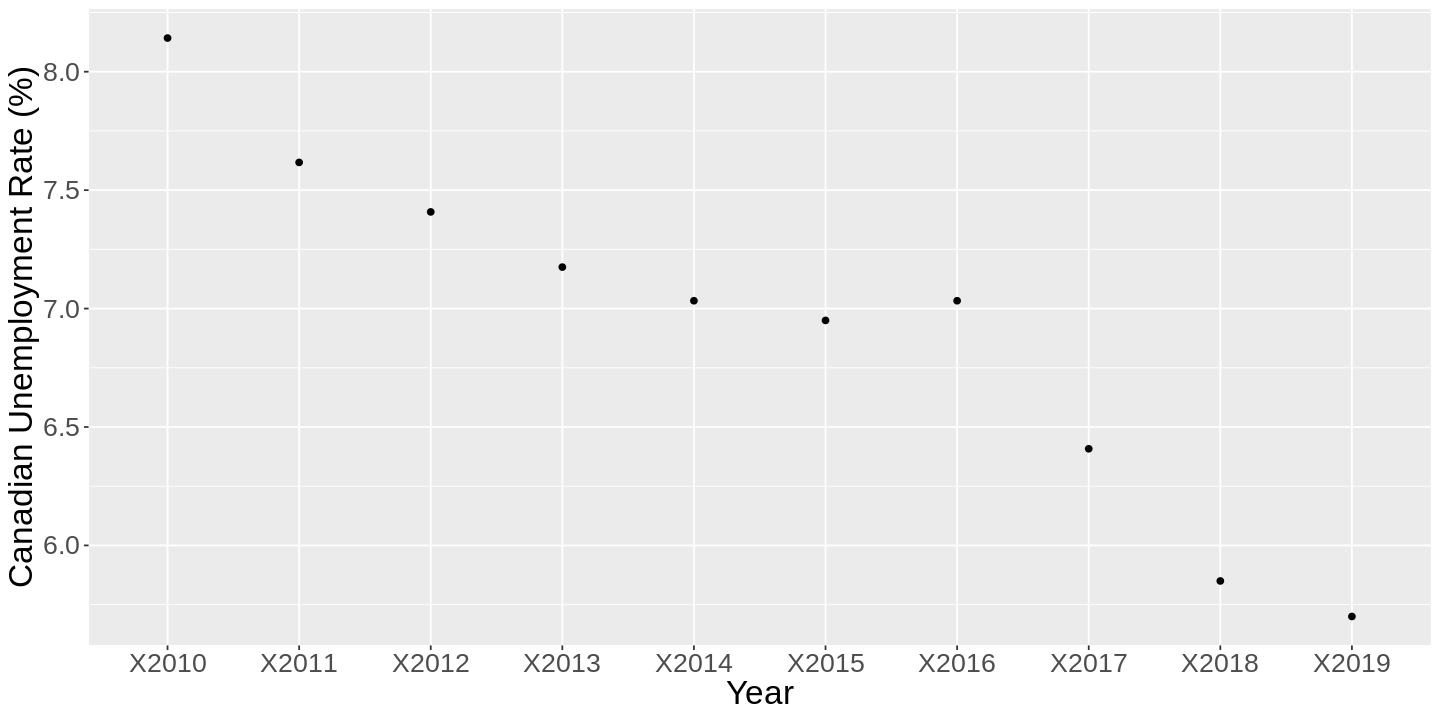

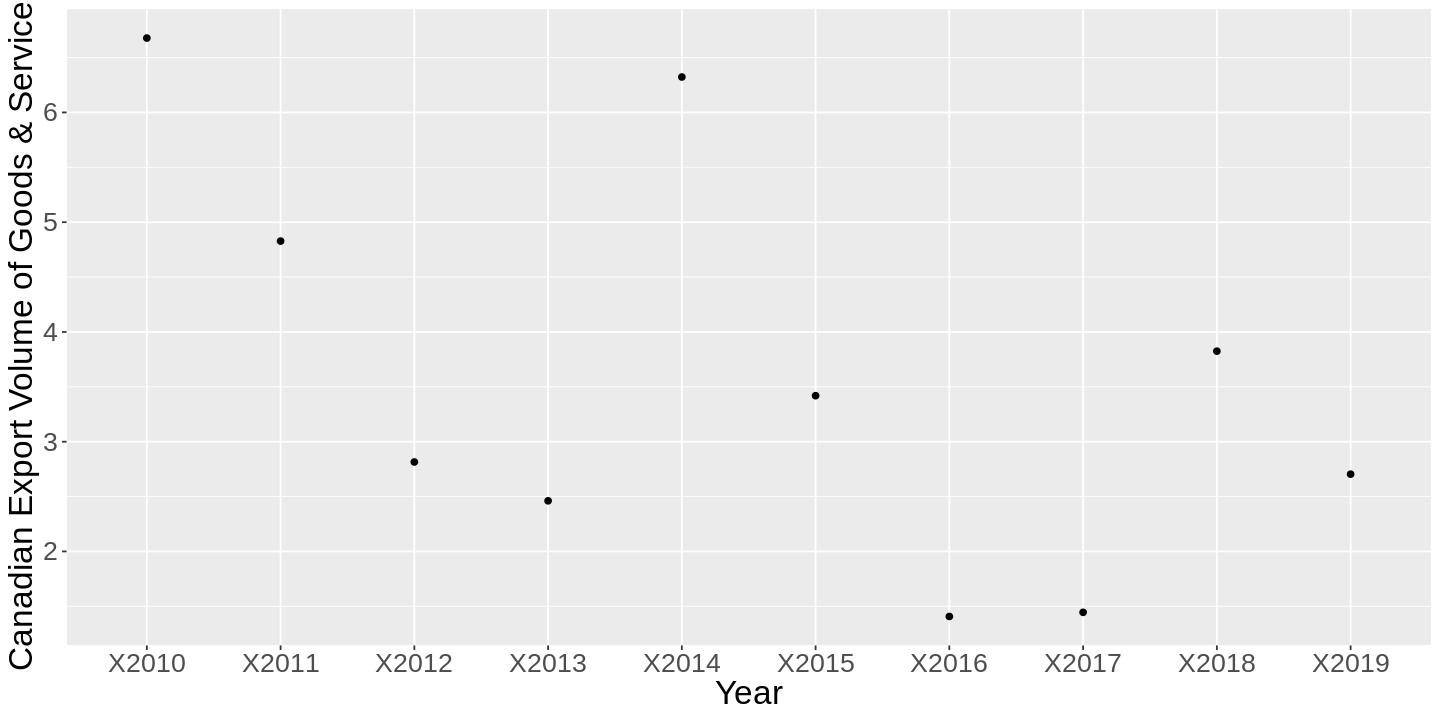

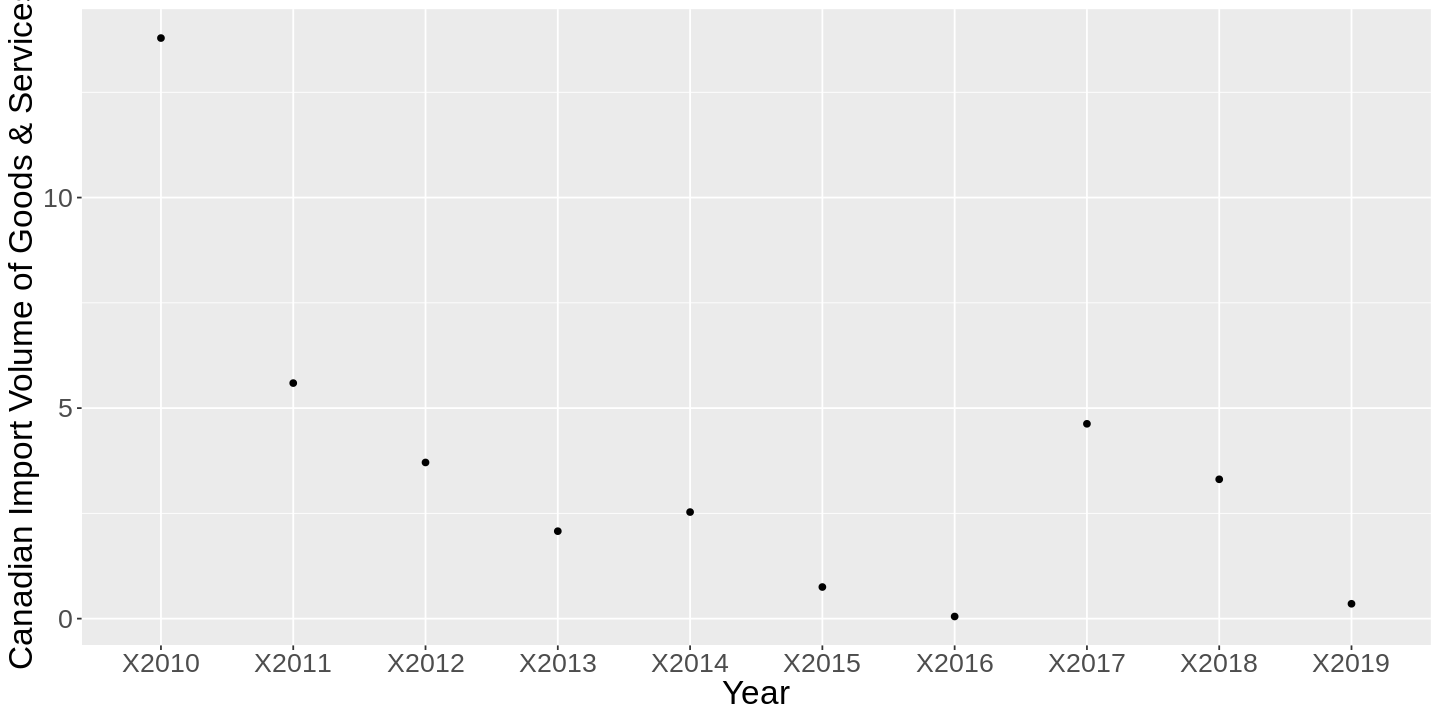

In [104]:
can_inflation_var_visuals <- canada_pre_2020_df |>
    ggplot(aes(x = Year, y = Inflation..average.consumer.prices, z = Year)) + 
        geom_point() +
        xlab("Year") +
        ylab("Inflation Rate of Average Consumer Prices (%)") + 
        theme(text = element_text(size = 20))

can_unemployment_var_visuals <- canada_pre_2020_df |>
    ggplot(aes(x = Year, y = Unemployment.rate, z = Year)) + 
        geom_point() +
        xlab("Year") +
        ylab("Canadian Unemployment Rate (%)") + 
        theme(text = element_text(size = 20))

can_exports_var_visuals <- canada_pre_2020_df |>
    ggplot(aes(x = Year, y = Volume.of.exports.of.goods.and.services)) + 
        geom_point() +
        xlab("Year") +
        ylab("Canadian Export Volume of Goods & Services") + 
        theme(text = element_text(size = 20))

can_imports_var_visuals <- canada_pre_2020_df |>
    ggplot(aes(x = Year, y = Volume.of.imports.of.goods.and.services)) + 
        geom_point() +
        xlab("Year") +
        ylab("Canadian Import Volume of Goods & Services") + 
        theme(text = element_text(size = 20))

can_inflation_var_visuals
can_unemployment_var_visuals
can_exports_var_visuals
can_imports_var_visuals

In [105]:
can_split <- initial_split(canada_pre_2020_df, prop = 0.70, strata = Gross.domestic.product.per.capita..current.prices)
can_training <- training(can_split)
can_testing <- testing(can_split)

can_training

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 0 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


Country,Year,Gross.domestic.product.per.capita..current.prices,Inflation..average.consumer.prices,Unemployment.rate,Volume.of.exports.of.goods.and.services,Volume.of.imports.of.goods.and.services
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Canada,X2010,47627.35,1.777,8.142,6.678,13.788
Canada,X2011,52285.94,2.912,7.617,4.828,5.594
Canada,X2012,52744.00,1.516,7.408,2.815,3.709
Canada,X2014,51020.84,1.907,7.033,6.323,2.531
Canada,X2015,43626.47,1.125,6.950,3.419,0.751
Canada,X2016,42382.64,1.429,7.033,1.407,0.051
Canada,X2019,46449.96,1.949,5.700,2.704,0.353


In [ ]:
We split the data into a training set and testing set with a proportion of 70% before conducting any further analysis.

In [106]:
lm_can <- linear_reg() |>
        set_engine("lm") |>
        set_mode("regression")

lm_recipe_can <- recipe(Gross.domestic.product.per.capita..current.prices ~ Inflation..average.consumer.prices + Unemployment.rate + Volume.of.exports.of.goods.and.services + Volume.of.imports.of.goods.and.services, data = can_training)

lm_fit_can <- workflow() |>
        add_recipe(lm_recipe_can) |>
        add_model(lm_can) |>
        fit(data = can_training)

lm_fit_can

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                            (Intercept)  
                                27479.5  
     Inflation..average.consumer.prices  
                                 3778.4  
                      Unemployment.rate  
                                 1694.6  
Volume.of.exports.of.goods.and.services  
                                  634.2  
Volume.of.imports.of.goods.and.services  
                                 -234.6  


In [107]:
lm_can_test_results <- lm_fit_can |>
                predict(can_testing) |>
                bind_cols(can_testing) |>
                metrics(truth = Gross.domestic.product.per.capita..current.prices, estimate = .pred)

lm_rmspe <- lm_can_test_results |>
            filter(.metric == "rmse") |>
            select(.estimate) |>
            pull()

lm_rmspe

[1] 4946.423

In [ ]:
Above we calculated the RMSPE to evaluate the prediction accuracy of our KNN regression model on the testing data.

In [108]:
can_post_2020_econ_stats <- filter(tidy_G20_economic_data, Country == "Canada" & Year > "X2019")
can_post_2020_econ_stats

Country,Year,Gross.domestic.product.per.capita..current.prices,Inflation..average.consumer.prices,Unemployment.rate,Volume.of.exports.of.goods.and.services,Volume.of.imports.of.goods.and.services
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Canada,X2020,43383.71,0.717,9.725,-8.850,-9.331
Canada,X2021,52387.81,3.401,7.508,1.381,7.795
Canada,X2022,55085.45,6.797,5.275,2.580,7.254
Canada,X2023,52722.48,3.899,5.830,3.167,-1.613


In [109]:
can_gdp_preds <- lm_fit_can |>
    predict(can_post_2020_econ_stats) |>
    bind_cols(can_post_2020_econ_stats)

can_gdp_preds

.pred,Country,Year,Gross.domestic.product.per.capita..current.prices,Inflation..average.consumer.prices,Unemployment.rate,Volume.of.exports.of.goods.and.services,Volume.of.imports.of.goods.and.services
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43244.82,Canada,X2020,43383.71,0.717,9.725,-8.850,-9.331
52099.60,Canada,X2021,52387.81,3.401,7.508,1.381,7.795
62034.42,Canada,X2022,55085.45,6.797,5.275,2.580,7.254
54477.86,Canada,X2023,52722.48,3.899,5.830,3.167,-1.613


Here we make predictions on the test data using the predict function along with the bind_cols function to add a predictions column to our test datas

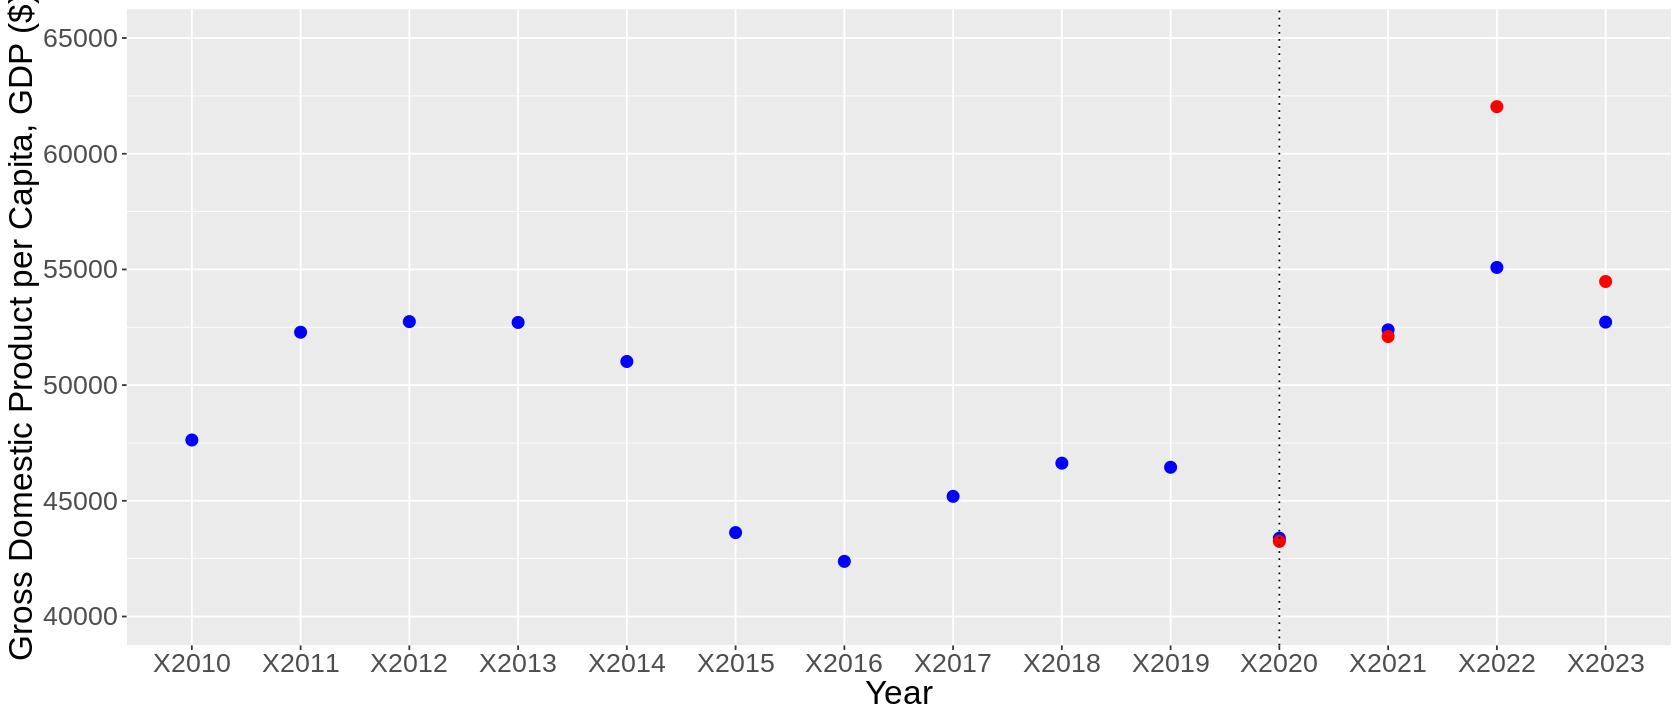

In [111]:
full_canada_data <- filter(tidy_G20_economic_data, Country == "Canada")
pred_values <- tibble(Year = c("X2020", "X2021", "X2022", "X2023"), Gross.domestic.product.per.capita..current.prices = c(43244.82, 52099.60, 62034.42, 54477.86))

options(repr.plot.height = , repr.plot.width = 14)
can_gdp_visual <- full_canada_data |>
    ggplot(aes(x = Year, y = Gross.domestic.product.per.capita..current.prices)) + 
        geom_point(color = "blue", size = 3) + 
        geom_point(data = pred_values, aes(x = Year, y = Gross.domestic.product.per.capita..current.prices), color = "red", size = 3) +
        geom_vline(xintercept = "X2020", linetype = "dotted") +
        ylim(min=40000, max=65000) +
        xlab("Year") +
        ylab("Gross Domestic Product per Capita, GDP ($)") + 
        theme(text = element_text(size = 20))

can_gdp_visual